In [1]:
import matplotlib 
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.io
import gc
import datetime
import time
import mat73
import hdf5storage
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, find_nearest_sorted, smooth_data
from _steady_state import a_steady, a_steady_with_sz
from _mbes import mbes, mbes_soc, mbes_no_cavity, mbes_soc_no_cavity
from _do_calculation import solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_mbes_general
#matplotlib.pyplot.switch_backend('nbagg')
#%qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr;
kappa = np.pi*fr/quali #HWHM
delta = spin_pars.delta #detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac #detuning drive to cavity wc-wp
gperp = spin_pars.gperp #HWHM
gpar = spin_pars.gpar#0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins#701#5000#20
nbins = spin_pars.nbins
g_number = spin_pars.g_number #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)


16.358325307119614


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

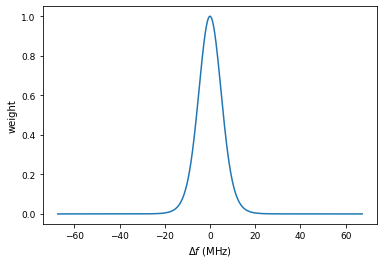

In [5]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');

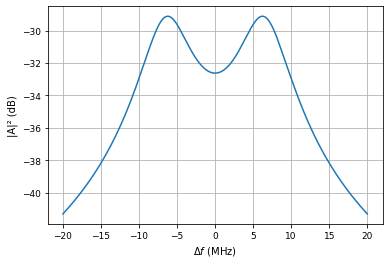

In [6]:
initsteady = (0.001,0.001)
fstart = 20
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))
gs_copl = gs[:len(pdf)]/np.linalg.norm(gs[:len(pdf)])*gcoll
newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs_copl, spins[:len(pdf)], gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(-deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)

# SOC pulses

In [7]:
pumptime = 50e-3#5*np.pi/gcoll
decaytime = 1000e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0


### Linear Pulse

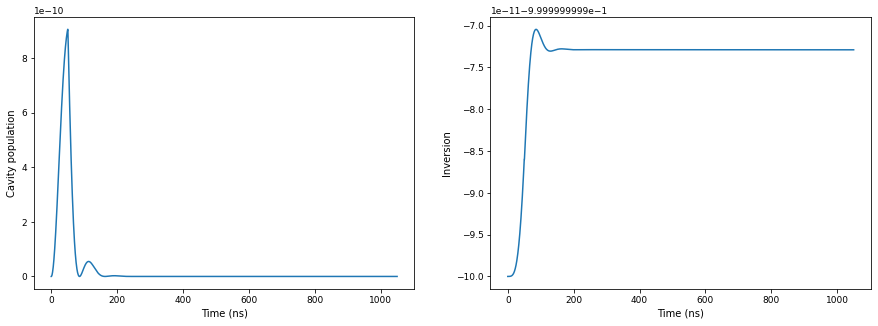

In [8]:
asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, 0.001, kappa, deltac, gs, gperp, spins, gpar)
alos_linear = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos_linear = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot_linear = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot_linear, alos_linear)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot_linear, szlos_linear)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

### Calibrate power and compare with data

In [9]:
file_powerscan = "/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210124_DoulbeChipRes_10/timeResolved/scan_pumpAttn_rectPulse/SCRIPT_pumpAttn_1/scan_pumpAttn_50ns_1.mat"
data_ps = mat73.loadmat(file_powerscan);
scan_values_ps = data_ps['scan_values']
iq_data_ps = np.asarray(data_ps['IQdata_scan'])
pl_idx = 6000
idx_s = 1800
p_end = -15

hori = float(data_ps['pars']['acqiris']['acqirisStruct']['horizontal']['sampInterval'])*1e9

idx, value = find_nearest(-scan_values_ps, p_end)

a2plot = (iq_data_ps[:idx,idx_s:pl_idx,0]**2+iq_data_ps[:idx,idx_s:pl_idx,1]**2)
aplotr = iq_data_ps[:idx,idx_s:pl_idx,0]
aploti = iq_data_ps[:idx,idx_s:pl_idx,1]
t = np.linspace(0, len(a2plot[0])*hori, len(a2plot[0]))
ilist_exp, qlist_exp = data_ps['measPars_scan'][0]['pump']['waveform']
tpump = np.arange(0, len(ilist_exp)*dt, dt)

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:ro

In [10]:
pin = np.arange(-35, -15,1)
aref = 1800
testphase = -np.pi/2*1.1

alos = np.zeros((len(pin), len(tpump)+len(tlistdecay)))
alosr = np.zeros(alos.shape)
alosi = np.zeros(alos.shape)
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tpump)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes_soc, init, pdf, tpump, tlistdecay, ilist_exp*dr, qlist_exp*dr, tpump, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    alosr[ctr, : ] = np.hstack((asolpump[:,0].real, asoldecay[:,0].real))
    alosi[ctr, : ] = np.hstack((asolpump[:,0].imag, asoldecay[:,0].imag))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

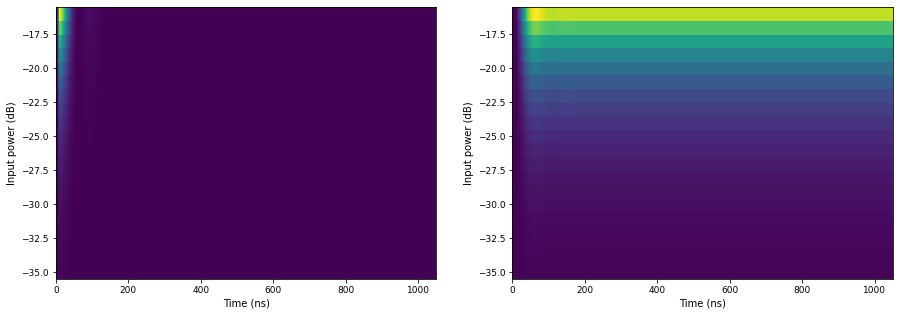

In [11]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tpump)+len(tlistdecay))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.pcolor(tplot, pin, alos, shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos, shading="auto")
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');
maxAmpl = abs(asolpump).max()

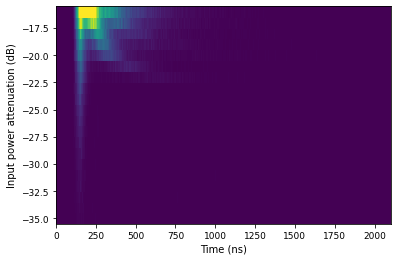

In [12]:
plt.pcolor(t, -scan_values_ps[:idx], a2plot, shading='auto', vmax=.2)
plt.xlabel('Time (ns)')
plt.ylabel('Input power attenuation (dB)');

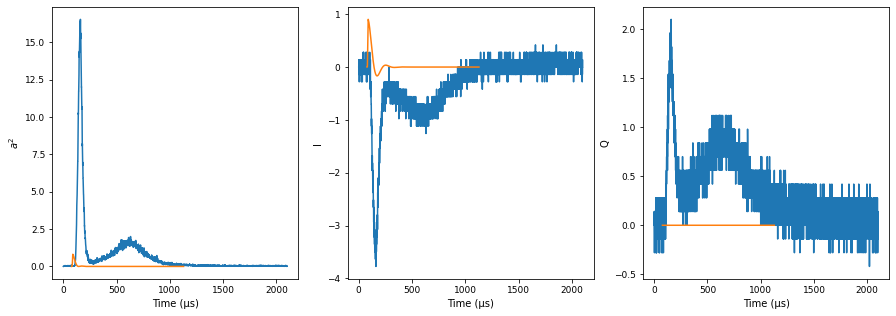

In [16]:
target_p =-22
ratio = 320
pretime = 78

idx_sim, value = find_nearest(pin, target_p)
idx_exp, value = find_nearest(-scan_values_ps, target_p)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(t, smooth_data(a2plot[idx_exp], 5)*ratio)
ax1.plot(tplot+pretime, alos[idx_sim])
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("$a^2$")


ax2.plot(t, np.sqrt(ratio)*aplotr[idx_exp])
ax2.plot(tplot+pretime, alosr[idx_sim])
ax2.set_xlabel("Time (µs)")
ax2.set_ylabel("I")


ax3.plot(t, np.sqrt(ratio)*aploti[idx_exp])
ax3.plot(tplot+pretime, alosi[idx_sim])
ax3.set_xlabel("Time (µs)")
ax3.set_ylabel("Q")
%qtconsole
#ax4.plot(tplot+pretime, szlos[idx_sim])

## Detuned

### Compare with data

In [9]:
file_powerscan = "/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210124_DoulbeChipRes_10/timeResolved/scan_pumpAttn_rectPulse_dispersive20MHz/SCRIPT_pumpAttn_dispersive_1/scan_pumpAttn_200ns_23MHz_detuned_1.mat"
data_ps = mat73.loadmat(file_powerscan)
scan_values_ps_det = np.asarray(np.squeeze(data_ps['scan_values']), dtype=float)
iq_data_ps = np.asarray(data_ps['IQdata_scan'])
iq_data_ps = np.asarray([val for val in iq_data_ps])
pl_idx = 3500
idx_s = 1790
p_end = 0

idx, value = find_nearest(-scan_values_ps_det, p_end)
a2plot_det = (iq_data_ps[:idx,idx_s:pl_idx,0]**2+iq_data_ps[:idx,idx_s:pl_idx,1]**2)
aplotr_det = iq_data_ps[:idx,idx_s:pl_idx,0]
aploti_det = iq_data_ps[:idx,idx_s:pl_idx,1]
t_det = np.linspace(0, len(a2plot_det[0])*hori, len(a2plot_det[0]))

AssertionError: /mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210124_DoulbeChipRes_10/timeResolved/scan_pumpAttn_rectPulse_dispersive20MHz/SCRIPT_pumpAttn_dispersive_1/scan_pumpAttn_200ns_23MHz_detuned_1.mat does not exist

In [11]:
plt.pcolor(t_det, -scan_values_ps_det[:idx], a2plot_det, shading='auto')
plt.xlabel("Time (µs)")
plt.ylabel("Input attenuation (dB)")
ilist_exp_det, qlist_exp_det = data_ps['measPars_scan'][0]['pump']['waveform']
tpump_det = np.arange(0, len(ilist_exp_det)*dt, dt)
tpump_det =  np.arange(0, 100e-3+dt, dt)

NameError: name 't_det' is not defined

In [10]:
pin_det = np.arange(-35, 0,0.5)
aref_det = 5400


alos_det = np.zeros((len(pin_det), len(tpump_det)+len(tlistdecay)))
alos_det_ampl = np.zeros((len(pin_det), len(tpump_det)+len(tlistdecay)), dtype=complex)
alosr_det = np.zeros((len(pin_det), len(tpump_det)+len(tlistdecay)))
alosi_det = np.zeros((len(pin_det), len(tpump_det)+len(tlistdecay)))
szlos_det = np.zeros(np.shape(alos_det))
szall_det = np.zeros((len(pin_det), len(tpump_det)+len(tlistdecay), nbins))
small_det = np.zeros(np.shape(szall_det))
smlos_det = np.zeros(np.shape(alos_det))


detuning = -22
#careful here if spins are detuned 20MHz to the left, deltac becomes positive (because it is wc-wp)
deltac_det = -2*np.pi*detuning

for ctr, p in enumerate(pin_det):
    dr = aref_det*10**(p/20.)
    
    asolpump, asoldecay, infodict = solve_mbes(mbes_soc, init, pdf, tpump_det, tlistdecay, ilist_exp_det*dr, qlist_exp_det*dr, tpump_det, kappa, deltac_det, gs, gperp, spins+detuning, gpar)
    alos_det[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    alosr_det[ctr, : ] = np.hstack((asolpump[:,0].real, asoldecay[:,0].real))
    alosi_det[ctr, : ] = np.hstack((asolpump[:,0].imag, asoldecay[:,0].imag))
    alos_det_ampl[ctr, :] = np.hstack((asolpump[:,0], asoldecay[:,0]))
    szlos_det[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall_det[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small_det[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos_det[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

NameError: name 'tpump_det' is not defined

TypeError: only size-1 arrays can be converted to Python scalars

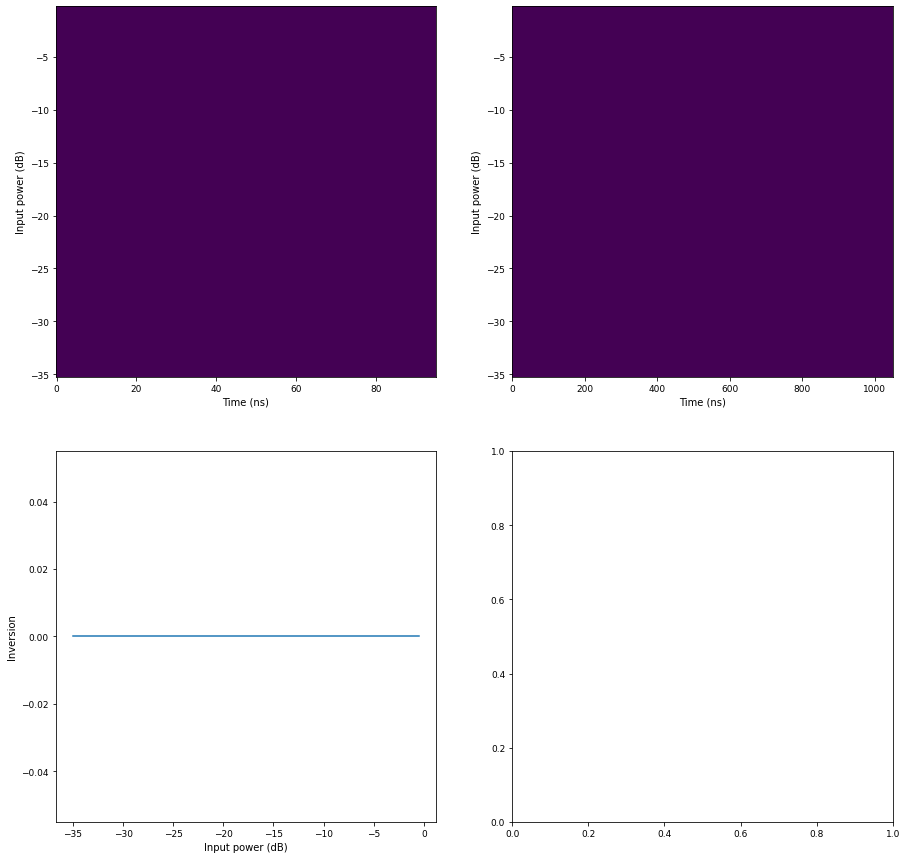

In [20]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tpump_det)+len(tlistdecay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
ax1.pcolor(tplot[:200], pin_det, alos_det[:,:200], shading="auto")
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin_det, szlos_det, shading="auto")
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');
maxAmpl = abs(asolpump).max()

ax3.plot(pin_det, szlos_det[:, -1])
ax3.set_xlabel("Input power (dB)")
ax3.set_ylabel("Inversion");


idxinv = int(np.where(szlos_det[:, -1]==np.max(szlos_det[:, -1]))[0])
ax4.plot(tplot, szlos_det[idxinv, :])
ax4.set_xlabel("Time (ns)")
ax4.set_ylabel("Polarization");

Text(0, 0.5, '$a^2$')

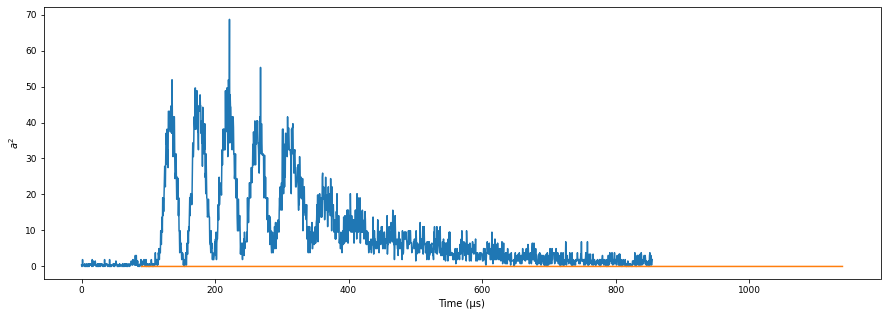

In [21]:
target_p =-12
ratio = 1000

pretime_det = 90

idx_sim, value = find_nearest(pin_det, target_p)
idx_exp, value = find_nearest(-scan_values_ps_det, target_p)

fig, (ax1) = plt.subplots(1,1, figsize=(15,5))
ax1.plot(t_det, a2plot_det[idx_exp]*ratio)
ax1.plot(tplot+pretime_det, alos_det[idx_sim])
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("$a^2$")

#ax2.plot(t_det, np.sqrt(ratio)*aplotr_det[idx_exp])
#ax2.plot(tplot+pretime, alosr_det[idx_sim])
#ax2.set_xlabel("Time (µs)")
#ax2.set_ylabel("I")

#ax3.plot(t_det, np.sqrt(ratio)*aploti_det[idx_exp])
#ax3.plot(tplot+pretime, alosi_det[idx_sim])
#ax3.set_xlabel("Time (µs)")
#ax3.set_ylabel("Q")

### Calculating dispersive shifts

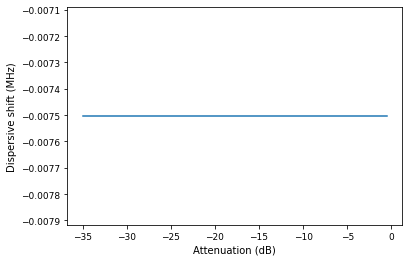

In [22]:
szendall = szall_det[:, -1, :]
initsteady = (0.001,0.001)
fstart2 = 15
deltaarr2 = np.linspace(-fstart2*2*np.pi,fstart2*2*np.pi, 2000)


losasteady = np.zeros((len(pin_det), len(deltaarr2)))
losareal = np.zeros((len(pin_det), len(deltaarr2)))
losaimag = np.zeros((len(pin_det), len(deltaarr2)))
max_freqs = np.zeros(len(pin_det))

for j, szval in enumerate(szendall):    
    for i, delt in enumerate(deltaarr2):
        ar, ai = a_steady_with_sz(etasteady, delt, gs, spins+detuning, gpar, gperp, kappa, szendall[j, :]/pdf)
        losareal[j, i] = ar
        losaimag[j, i] = ai
        losasteady[j, i] = np.sqrt(ai**2+ar**2)
    maxidx = int(np.where(losasteady[j, :] == max(losasteady[j, :]))[0][0])
    max_freqs[j] = deltaarr2[maxidx]
plt.plot(pin_det, max_freqs/2/np.pi)
plt.xlabel("Attenuation (dB)")
plt.ylabel("Dispersive shift (MHz)");

### OCT Pulses

In [12]:
fcomps = np.array([-1.177,  1.646, -0.549, -1.668, -0.627,  0.151,  1.68 , -0.024,
        0.858,  1.311, -0.15 , -0.355,  0.253,  1.165,  0.069,  0.47 ,
       -0.649, -0.814,  0.643, -0.657])
tscale_pulse = 2
wgrund = 2*np.pi/tscale_pulse
nfreqs = int(len(fcomps)/2)

tp = np.arange(0, 0.504*tscale_pulse, dt)

dtf = 0.0005
tpf = np.arange(0, tp[-1]+dtf, dtf)
init = np.ones(nbins*2)*(-1)
init[::2] = 0

ascalelist = np.linspace(0, 7, 100)
pulselist = []


for ascale in ascalelist:
    pulseif = pulse_rwa(tpf, (wgrund, fcomps[:nfreqs]))
    pulseqf = pulse_rwa(tpf, (wgrund, fcomps[nfreqs:]))

    pulsei = pulse_rwa(tp, (wgrund, fcomps[:nfreqs]))
    pulseq = pulse_rwa(tp, (wgrund, fcomps[nfreqs:]))
    pulsei *= ascale
    pulseq *= ascale
    pulseif *= ascale
    pulseqf *= ascale
    #this is what the spins do if they see a cavity field of "pulsei, pulseq"
    solutionpump, infodict = solve_mbes_without_cavity(mbes_soc_no_cavity, init, pdf, tp, None, pulsei, pulseq, tp, deltac_det, gs, gperp, spins+detuning, gpar)

    sm = solutionpump[:, ::2]/pdf
    #given the solution to the predefined cavity field, how do i have to change the pulses in order to make the cavity field to be like pulsei, pulseq
    ipulse, qpulse = get_pulses_from_cavity_field(pulsei+ 1j*pulseq, pulseif+1j*pulseqf, sm, tp, tpf, kappa, deltac_det, gs)
    pulselist.append([ipulse, qpulse])
pulselist = np.asarray(pulselist)


solutionp = []
solutiond = []
#with the modified pulses, how to the solutions for the pulses look like
for pulse in pulselist:
    init = np.ones(nbins*g_number*2+1)*(-1)
    init[0] = 0
    init[1::2] = 0
    ipulse = pulse[0]
    qpulse = pulse[1]
        
    solutionpump2, soldecay, infodict = solve_mbes(mbes_soc, init, pdf, tp, tlistdecay, ipulse, qpulse, tp, kappa, deltac_det, gs, gperp*0.1, spins+detuning, gpar)
    solutionp.append(solutionpump2)
    solutiond.append(soldecay)
solutiond = np.asarray(solutiond)
solutionp = np.asarray(solutionp)
solution = np.hstack((solutionp, solutiond))

NameError: name 'deltac_det' is not defined

2.2626262626262625


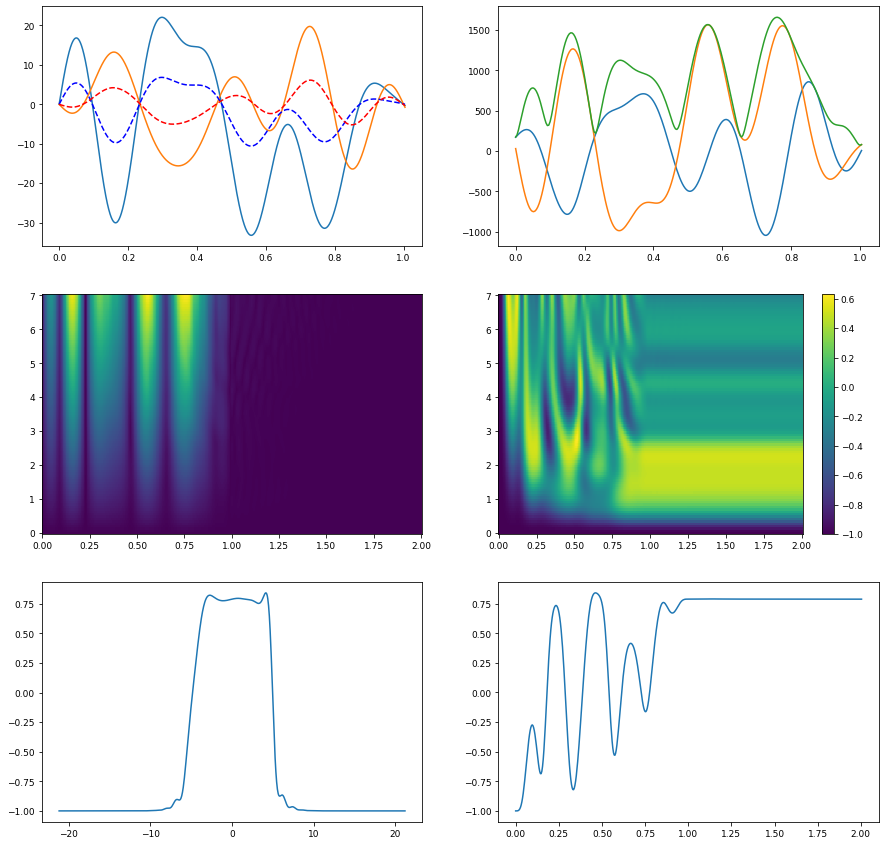

In [276]:
szr = np.sum(solution[:, :, 2::2], axis=2).real

idealidx =int(np.where(szr[:,-1]==np.max(szr[:,-1]))[0])
print(ascalelist[idealidx])
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3,2,figsize=(15,15))

ax0.plot(tpf, pulseif)
ax0.plot(tpf, pulseqf)
ax0.plot(tp, solutionp[idealidx, :,0].real, 'b--')
ax0.plot(tp, solutionp[idealidx, :,0].imag, 'r--')

ax1.plot(tp, pulselist[idealidx][0])
ax1.plot(tp, pulselist[idealidx][1])
ax1.plot(tp, (pulselist[idealidx][0]**2+pulselist[idealidx][1]**2)**0.5)

tall = np.linspace(0, tp[-1]+tlistdecay[-1], len(solution[0]))

ax2.pcolor(tall, ascalelist, abs(solution[:, :, 0]), shading='auto')
c = ax3.pcolor(tall, ascalelist, szr, shading='auto')
fig.colorbar(c, ax=ax3)

middleidx = int(nbins/2)
idxm = 50
ax4.plot(spins, np.real(solution[idealidx, -1, 2::2]/pdf))

#ax5.plot(tp, solutionpump2[:, 0].real)
#ax5.plot(tp, solutionpump2[:, 0].imag)
#ax5.plot(tp, abs(solutionpump2[:, 0]))
#ax5.plot(tlistdecay+tp[-1], abs(soldecay[:,0]))

solutionideal = solution[idealidx]

ax5.plot(tall, np.sum(solutionideal[:,2::2][:, int(nbins/2)-idxm:int(nbins/2)+idxm]/pdf[int(nbins/2)-idxm:int(nbins/2)+idxm]/idxm/2, axis=1).real)
scipy.io.savemat("/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20210124_DoulbeChipRes_10/oct.mat", {'tend':tp[-1], 'puls':pulselist[idealidx]})

### Dispersive shift for OCT

Text(0, 0.5, 'Dispersive shift')

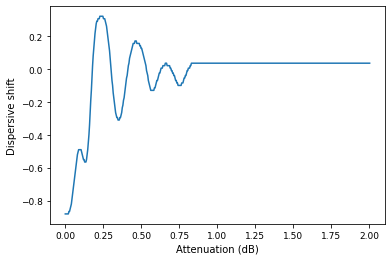

In [252]:
szendall_oct = solution[idealidx, :, 2::2]


losasteady_oct = np.zeros((len(tall), len(deltaarr2)))
losareal_oct = np.zeros((len(tall), len(deltaarr2)))
losaimag_oct = np.zeros((len(tall), len(deltaarr2)))
max_freqs_oct = np.zeros(len(tall))

for j, szval in enumerate(szendall_oct):    
    for i, delt in enumerate(deltaarr2):
        ar, ai = a_steady_with_sz(etasteady, delt, gs, spins+detuning, gpar, gperp, kappa, szendall_oct[j, :]/pdf)
        losareal_oct[j, i] = ar
        losaimag_oct[j, i] = ai
        losasteady_oct[j, i] = np.sqrt(ai**2+ar**2)
    maxidx = int(np.where(losasteady_oct[j, :] == max(losasteady_oct[j, :]))[0][0])
    max_freqs_oct[j] = deltaarr2[maxidx]
plt.plot(tall, max_freqs_oct/2/np.pi)
plt.xlabel("Attenuation (dB)")
plt.ylabel("Dispersive shift")